
# 7-5，FiBiNET模型

神经网络的结构设计有3个主流的高级技巧：

* 1，高低融合 (将高层次特征与低层次特征融合，提升特征维度的丰富性和多样性，像人一样同时考虑整体和细节)
* 2，权值共享 (一个权值矩阵参与多个不同的计算，降低参数规模并同时缓解样本稀疏性，像人一样一条知识多处运用)
* 3，动态适应 (不同的输入样本使用不同的权值矩阵，动态地进行特征选择并赋予特征重要度解释性，像人一样聚焦重要信息排除干扰信息)

技巧应用范例：

* 1，高低融合 (DeepWide,UNet,特征金字塔FPN...)
* 2，权值共享 (CNN,RNN,FM,DeepFM,BlinearFFM...)
* 3，动态适应 (各种Attention机制...)

新浪微博广告推荐技术团队2019年发布的CTR预估模型FiBiNET同时巧妙地运用了以上3种技巧，是神经网络结构设计的教科书级的范例。

在此介绍给大家。

参考资料：
* FiBiNET论文：https://arxiv.org/pdf/1905.09433.pdf
* FiBiNET-结合特征重要性和双线性特征交互进行CTR预估：https://zhuanlan.zhihu.com/p/72931811
* 代码实现：https://github.com/xue-pai/FuxiCTR/blob/main/fuxictr/pytorch/models/FiBiNET.py 
* SENet原理：https://zhuanlan.zhihu.com/p/65459972

<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


## 一，FiBiNET原理解析

FiBiNET全称为Feature Importance and Bilinear Interaction Network.

顾名思义，其主要的创意有2个。

第一个是Feature Importance，通过借鉴SENet（Squeeze-and-Excitation）Attention机制实现特征选择和重要度解释。

第二个是Bilinear Interaction Network，这是应用权值共享技巧对 FFM(Field-Aware FM)结构进行改进的一种结构。

同时，FiBiNET保留了DeepWide的高低融合的网络架构。

所以它综合使用了 高低融合、权值共享、动态适应 这3种神经网络结构设计的高级技巧。一个不落，Triple kill!

我们重点介绍一下 SENet Attention 和 Bilinear Interaction.

### 1, SENet Attention 

SENet 全称为 Squeeze-and-Excitation Network，是一种通过注意力机制计算特征重要度的网络模块。

最早是在CV领域引入，通过在ResNet结构上添加SENet Attention模块，赢得了ImageNet 2017竞赛分类任务的冠军。

如何计算各个Feature Map(通道)的特征重要度(注意力权重)呢？

SENet的思想非常简洁。

step1: 通过全局池化将各个Feature Map由一个一个的矩阵汇总成一个一个的标量。此即Squeeze操作。

step2：通过一个2层MLP将汇总成得到的一个一个的标量所构成的向量进行变换，得到注意力权重。此即Excitation操作。 
细节一点地说，这个2层的MLP的第1层将通道数量缩减成原来的1/3, 第2层再将通道数恢复。并且每层后面都接入了激活函数。

step3：用注意力权重乘以原始的Feature Map。这个是Re-Weight操作。

图片示意如下。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h2sfkkfcy3j208w06fgll.jpg)


pytorch代码实现如下，可能比图片更加好懂。

In [1]:
import torch 
from torch import nn 
class SENetAttention(nn.Module):
    """
    Squeeze-and-Excitation Attention
    输入shape: [batch_size, num_fields, d_embed]   #num_fields即num_features
    输出shape: [batch_size, num_fields, d_embed]
    """
    def __init__(self, num_fields, reduction_ratio=3):
        super().__init__()
        reduced_size = max(1, int(num_fields / reduction_ratio))
        self.excitation = nn.Sequential(nn.Linear(num_fields, reduced_size, bias=False),
                                        nn.ReLU(),
                                        nn.Linear(reduced_size, num_fields, bias=False),
                                        nn.ReLU())

    def forward(self, x):
        Z = torch.mean(x, dim=-1, out=None) #1,Sequeeze
        A = self.excitation(Z) #2,Excitation
        V = x * A.unsqueeze(-1) #3,Re-Weight
        return V

### 2, Bilinear Interaction 

Bilinear Interaction实际上是FFM在权值共享思想下的一种改进，也可以称之为Bilinear FFM。

我们先说说FFM(Field-Aware FM)，再看看这个Bilinear FFM 怎么改进的。

FM用隐向量之间的点积来计算特征之间的交叉，并且一个特征用一个隐向量来表示。

FFM认为一个特征用一个隐向量来表达太粗糙了，如果这个特征和不同分组(Field)的特征来做交叉，应该用不同的隐向量。

举例来说，考虑一个广告点击预测的场景，广告类别 和 用户所在城市、用户职业之间的交叉。

在FM中 一个确定的广告类别 比如游戏广告 不论是和用户所在城市，还是用户职业交叉，都用同一个隐向量。

但是FFM认为，用户所在城市和用户职业是两类完全不同的特征(不同Field)，描述它们的向量空间应该是完全不相关的，FM用一个相同的隐向量来和它们做点积不合理。

所以，FFM引入了Field(域)的概念，和不同Field的特征做交叉，要使用不同的隐向量。

实践表明，FFM这个思路是有效的, FFM的作者阮毓钦正是凭借这个方案赢得了2015年kaggle举办的Criteo比赛的冠军。

但是FFM有个很大的缺点，就是参数量太多了。

对于FM来说，每个特征只有一个隐向量，假设有n个特征，每个隐向量维度为k，全部隐向量参数矩阵的大小 size = n k.

但是对于FFM，有过有f个不同的field，每个特征都将有f-1个隐向量，全部隐向量的参数矩阵的大小增大为 size = (f-1) n k. 

通常的应用场景中，Field的数量有几十几百维，而Feature的数量有数万数百万维。

很显然，FFM将隐向量的参数规模扩大了几十几百倍。

FFM的本质思想是在做特征交叉的时候要区分不同的Field，其实现方式是和不同的Field做交叉时用不同的隐向量。

有没有办法保留FFM中区分不同Field的特性，并降低参数规模呢？

BilinearFFM说，我有办法，权重共享走起来！

BilinearFFM不直接针对不同Field设计不同的隐向量，而是引入了Field变换矩阵来区分不同的Field。

每个特征还是一个隐向量，但是和不同的Field的特征做交叉时，先乘上这个特征所在Field的变换矩阵，然后再做后面的点积。

因此，同属一个Field的特征共享一个Field变换矩阵。这种bilinear_type叫做 field_each.

Field变换矩阵的大小是k^2, 这种方式下，全部隐向量的参数大小加上共享变换矩阵的参数大小一共是 size = n k + f k^2 

由于k和f远小于n，这种Bilinear方式相比FM增加的参数量可以忽略不计。


除了 同属一个Field的特征共享一个Field变换矩阵外，我们还可以更加简单粗暴一点，所有特征共享一个变换矩阵.

这种bilinear_type叫做 field_all.这种方式下，size = n k + k^2 


我们也可以更加精细一点，相同的Field组合之间的交互共享一个变换矩阵，这种bilinear_type叫做field_interaction. 

总共有f(f-1)/2种组合，这种方式下， size = n k + k^2 f(f-1)/2

以上就是BilinearFFM的基本思想。


FiBiNET中用到的Bilinear Interaction相比BilinearFFM, 还有一处小改动，将点积改成了哈达玛积，如下图所示。


![](https://tva1.sinaimg.cn/large/e6c9d24egy1h2sfj6wh0rj209v08daad.jpg)

pytorch代码实现如下，整体不难理解。作2点说明。

1，Field概念说明

在FFM相关的文章中，引入了Field的概念，以和Feature区分，一个Field中可以包括多个Feature. 

实际上Field就是我们通常理解的特征，包括数值特征和类别特征，但是Feature是数值特征或者类别特征onehot后的特征。一个类别特征对应一个Field，但是对应多个Feature。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h2sh8t8j6pj20gc058mx9.jpg)

2，combinations函数说明

组合函数combinations从num_fields中任取2种作为组合，共有 num_fields*(num_fields-1)中组合方式。

所以输出的Field数量变成了 num_fields*(num_fields-1)/2。

In [2]:
import torch 
from torch import nn 
from itertools import combinations
class BilinearInteraction(nn.Module):
    """
    双线性FFM
    输入shape: [batch_size, num_fields, d_embed] #num_fields即num_features
    输出shape: [batch_size, num_fields*(num_fields-1)/2, d_embed]
    """
    def __init__(self, num_fields, d_embed, bilinear_type="field_interaction"):
        super().__init__()
        self.bilinear_type = bilinear_type
        if self.bilinear_type == "field_all":
            self.bilinear_layer = nn.Linear(d_embed, d_embed, bias=False)
        elif self.bilinear_type == "field_each":
            self.bilinear_layer = nn.ModuleList([nn.Linear(d_embed, d_embed, bias=False)
                                                 for i in range(num_fields)])
        elif self.bilinear_type == "field_interaction":
            self.bilinear_layer = nn.ModuleList([nn.Linear(d_embed, d_embed, bias=False)
                                                 for i, j in combinations(range(num_fields), 2)])
        else:
            raise NotImplementedError()

    def forward(self, feature_emb):
        feature_emb_list = torch.split(feature_emb, 1, dim=1)
        if self.bilinear_type == "field_all":
            bilinear_list = [self.bilinear_layer(v_i) * v_j
                             for v_i, v_j in combinations(feature_emb_list, 2)]
        elif self.bilinear_type == "field_each":
            bilinear_list = [self.bilinear_layer[i](feature_emb_list[i]) * feature_emb_list[j]
                             for i, j in combinations(range(len(feature_emb_list)), 2)]
        elif self.bilinear_type == "field_interaction":
            bilinear_list = [self.bilinear_layer[i](v[0]) * v[1]
                             for i, v in enumerate(combinations(feature_emb_list, 2))]
        return torch.cat(bilinear_list, dim=1)

### 二，FiBiNET的pytorch实现

下面是FiBiNET的一个pytorch实现。

核心代码是SENetAttention模块和BilinearInteraction模块的实现。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h2sffi4huoj20g70a4gm4.jpg)

In [3]:
import torch 
from torch import nn 
from itertools import combinations

class NumEmbedding(nn.Module):
    """
    连续特征用linear层编码
    输入shape: [batch_size,num_features, d_in], # d_in 通常是1
    输出shape: [batch_size,num_features, d_out]
    """
    
    def __init__(self, n: int, d_in: int, d_out: int, bias: bool = False) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(n, d_in, d_out))
        self.bias = nn.Parameter(torch.Tensor(n, d_out)) if bias else None
        with torch.no_grad():
            for i in range(n):
                layer = nn.Linear(d_in, d_out)
                self.weight[i] = layer.weight.T
                if self.bias is not None:
                    self.bias[i] = layer.bias

    def forward(self, x_num):
        assert x_num.ndim == 3
        #x = x_num[..., None] * self.weight[None]
        #x = x.sum(-2)
        x = torch.einsum("bfi,fij->bfj",x_num,self.weight)
        if self.bias is not None:
            x = x + self.bias[None]
        return x
    
class CatEmbedding(nn.Module):
    """
    离散特征用Embedding层编码
    输入shape: [batch_size, num_features], 
    输出shape: [batch_size, num_features, d_embed]
    """
    def __init__(self, categories, d_embed):
        super().__init__()
        self.embedding = nn.Embedding(sum(categories), d_embed)
        self.offsets = nn.Parameter(
                torch.tensor([0] + categories[:-1]).cumsum(0),requires_grad=False)
        
        nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x_cat):
        """
        x_cat: Long tensor of size ``(batch_size, features_num)``
        """
        x = x_cat + self.offsets[None]
        return self.embedding(x) 
    
class CatLinear(nn.Module):
    """
    离散特征用Embedding实现线性层（等价于先F.onehot再nn.Linear()）
    输入shape: [batch_size, num_features ], 
    输出shape: [batch_size, d_out]
    """
    def __init__(self, categories, d_out=1):
        super().__init__()
        self.fc = nn.Embedding(sum(categories), d_out)
        self.bias = nn.Parameter(torch.zeros((d_out,)))
        self.offsets = nn.Parameter(
                torch.tensor([0] + categories[:-1]).cumsum(0),requires_grad=False)
        nn.init.xavier_uniform_(self.fc.weight.data)

    def forward(self, x_cat):
        """
        Long tensor of size ``(batch_size, num_features)``
        """
        x = x_cat + self.offsets[None]
        return torch.sum(self.fc(x), dim=1) + self.bias 
    
class SENetAttention(nn.Module):
    """
    Squeeze-and-Excitation Attention
    输入shape: [batch_size, num_fields, d_embed]   #num_fields即num_features
    输出shape: [batch_size, num_fields, d_embed]
    """
    def __init__(self, num_fields, reduction_ratio=3):
        super().__init__()
        reduced_size = max(1, int(num_fields / reduction_ratio))
        self.excitation = nn.Sequential(nn.Linear(num_fields, reduced_size, bias=False),
                                        nn.ReLU(),
                                        nn.Linear(reduced_size, num_fields, bias=False),
                                        nn.ReLU())

    def forward(self, x):
        Z = torch.mean(x, dim=-1, out=None) #1,Sequeeze
        A = self.excitation(Z) #2,Excitation
        V = x * A.unsqueeze(-1) #3,Re-Weight
        return V
    
class BilinearInteraction(nn.Module):
    """
    双线性FFM
    输入shape: [batch_size, num_fields, d_embed] #num_fields即num_features
    输出shape: [batch_size, num_fields*(num_fields-1)/2, d_embed]
    """
    def __init__(self, num_fields, d_embed, bilinear_type="field_interaction"):
        super().__init__()
        self.bilinear_type = bilinear_type
        if self.bilinear_type == "field_all":
            self.bilinear_layer = nn.Linear(d_embed, d_embed, bias=False)
        elif self.bilinear_type == "field_each":
            self.bilinear_layer = nn.ModuleList([nn.Linear(d_embed, d_embed, bias=False)
                                                 for i in range(num_fields)])
        elif self.bilinear_type == "field_interaction":
            self.bilinear_layer = nn.ModuleList([nn.Linear(d_embed, d_embed, bias=False)
                                                 for i, j in combinations(range(num_fields), 2)])
        else:
            raise NotImplementedError()

    def forward(self, feature_emb):
        feature_emb_list = torch.split(feature_emb, 1, dim=1)
        if self.bilinear_type == "field_all":
            bilinear_list = [self.bilinear_layer(v_i) * v_j
                             for v_i, v_j in combinations(feature_emb_list, 2)]
        elif self.bilinear_type == "field_each":
            bilinear_list = [self.bilinear_layer[i](feature_emb_list[i]) * feature_emb_list[j]
                             for i, j in combinations(range(len(feature_emb_list)), 2)]
        elif self.bilinear_type == "field_interaction":
            bilinear_list = [self.bilinear_layer[i](v[0]) * v[1]
                             for i, v in enumerate(combinations(feature_emb_list, 2))]
        return torch.cat(bilinear_list, dim=1)
    

#mlp
class MultiLayerPerceptron(nn.Module):
    def __init__(self, d_in, d_layers, dropout, 
                 d_out = 1):
        super().__init__()
        layers = []
        for d in d_layers:
            layers.append(nn.Linear(d_in, d))
            layers.append(nn.BatchNorm1d(d))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = d
        layers.append(nn.Linear(d_layers[-1], d_out))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        """
        float tensor of size ``(batch_size, d_in)``
        """
        return self.mlp(x)
    

#fibinet 
class FiBiNET(nn.Module):
    
    def __init__(self,
                 d_numerical, 
                 categories, 
                 d_embed,
                 mlp_layers, 
                 mlp_dropout,
                 reduction_ratio = 3,
                 bilinear_type = "field_interaction",
                 n_classes = 1):
        
        super().__init__()
        
        if d_numerical is None:
            d_numerical = 0
        if categories is None:
            categories = []
            
        self.categories = categories
        self.n_classes = n_classes
        
        self.num_linear = nn.Linear(d_numerical,n_classes) if d_numerical else None
        self.cat_linear = CatLinear(categories,n_classes) if categories else None
        
        self.num_embedding = NumEmbedding(d_numerical,1,d_embed) if d_numerical else None
        self.cat_embedding = CatEmbedding(categories, d_embed) if categories else None
        
        num_fields = d_numerical+len(categories)
        
        self.se_attention = SENetAttention(num_fields, reduction_ratio)
        self.bilinear = BilinearInteraction(num_fields, d_embed, bilinear_type)
        
        mlp_in = num_fields * (num_fields - 1) * d_embed
        self.mlp = MultiLayerPerceptron(
            d_in= mlp_in,
            d_layers = mlp_layers,
            dropout = mlp_dropout,
            d_out = n_classes
        )
        
        
    def forward(self, x):
        """
        x_num: numerical features
        x_cat: category features
        """
        x_num,x_cat = x
        
        #一，wide部分
        x_linear = 0.0
        if self.num_linear:
            x_linear = x_linear + self.num_linear(x_num) 
        if self.cat_linear:
            x_linear = x_linear + self.cat_linear(x_cat)
            
        #二，deep部分 
        
        #1，embedding
        x_embedding = []
        if self.num_embedding:
            x_embedding.append(self.num_embedding(x_num[...,None]))
        if self.cat_embedding:
            x_embedding.append(self.cat_embedding(x_cat))
        x_embedding = torch.cat(x_embedding,dim=1)
        
        #2，interaction
        se_embedding = self.se_attention(x_embedding)
        ffm_out = self.bilinear(x_embedding)
        se_ffm_out = self.bilinear(se_embedding)
        x_interaction = torch.flatten(torch.cat([ffm_out, se_ffm_out], dim=1), start_dim=1)
        
        #3，mlp
        x_deep = self.mlp(x_interaction)
        
        #三，高低融合
        x_out = x_linear+x_deep
        if self.n_classes==1:
            x_out = x_out.squeeze(-1)
        return x_out

In [4]:
##测试 FiBiNET

model = FiBiNET(d_numerical = 3, categories = [4,3,2],
        d_embed = 4, mlp_layers = [20,20], mlp_dropout=0.25,
        reduction_ratio = 3,
        bilinear_type = "field_interaction",
        n_classes = 1)

x_num = torch.randn(2,3)
x_cat = torch.randint(0,2,(2,3))
print(model((x_num,x_cat)))  


tensor([ 1.4711, -0.9382], grad_fn=<SqueezeBackward1>)


```
tensor([-0.8621,  0.6743], grad_fn=<SqueezeBackward1>)
```

## 三，Criteo数据集完整范例

Criteo数据集是一个经典的广告点击率CTR预测数据集。

这个数据集的目标是通过用户特征和广告特征来预测某条广告是否会为用户点击。

数据集有13维数值特征(I1-I13)和26维类别特征(C14-C39), 共39维特征, 特征中包含着许多缺失值。

训练集4000万个样本，测试集600万个样本。数据集大小超过100G.

此处使用的是采样100万个样本后的cretio_small数据集。 


In [5]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split 

import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader  
import torch.nn.functional as F 
import torchkeras 


### 1，准备数据

In [6]:
from sklearn.preprocessing import LabelEncoder,QuantileTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 

dfdata = pd.read_csv("./eat_pytorch_datasets/criteo_small.zip",sep="\t",header=None)
dfdata.columns = ["label"] + ["I"+str(x) for x in range(1,14)] + [
    "C"+str(x) for x in range(14,40)]

cat_cols = [x for x in dfdata.columns if x.startswith('C')]
num_cols = [x for x in dfdata.columns if x.startswith('I')]
num_pipe = Pipeline(steps = [('impute',SimpleImputer()),('quantile',QuantileTransformer())])

for col in cat_cols:
    dfdata[col]  = LabelEncoder().fit_transform(dfdata[col])

dfdata[num_cols] = num_pipe.fit_transform(dfdata[num_cols])

categories = [dfdata[col].max()+1 for col in cat_cols]


In [7]:
import torch 
from torch.utils.data import Dataset,DataLoader 

#DataFrame转换成torch数据集Dataset, 特征分割成X_num,X_cat方式
class DfDataset(Dataset):
    def __init__(self,df,
                 label_col,
                 num_features,
                 cat_features,
                 categories,
                 is_training=True):
        
        self.X_num = torch.tensor(df[num_features].values).float() if num_features else None
        self.X_cat = torch.tensor(df[cat_features].values).long() if cat_features else None
        self.Y = torch.tensor(df[label_col].values).float() 
        self.categories = categories
        self.is_training = is_training
    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        if self.is_training:
            return ((self.X_num[index],self.X_cat[index]),self.Y[index])
        else:
            return (self.X_num[index],self.X_cat[index])
    
    def get_categories(self):
        return self.categories
    

In [8]:
dftrain_val,dftest = train_test_split(dfdata,test_size=0.2)
dftrain,dfval = train_test_split(dftrain_val,test_size=0.2)

ds_train = DfDataset(dftrain,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)

ds_val = DfDataset(dfval,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)

ds_test = DfDataset(dftest,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)


In [9]:
dl_train = DataLoader(ds_train,batch_size = 2048,shuffle=True)
dl_val = DataLoader(ds_val,batch_size = 2048,shuffle=False)
dl_test = DataLoader(ds_test,batch_size = 2048,shuffle=False)

for features,labels in dl_train:
    break 
    

### 2，定义模型

In [10]:
def create_net():
    net = FiBiNET(
        d_numerical= ds_train.X_num.shape[1],
        categories= ds_train.get_categories(),
        d_embed = 8, mlp_layers = [128,64,32], mlp_dropout=0.25,
        reduction_ratio = 3,
        bilinear_type = "field_all",
        n_classes = 1
        
    )
    return net 

from torchkeras import summary

net = create_net()



### 3，训练模型

我们使用梦中情炉torchkeras来实现最优雅的训练循环。

In [11]:
from torchkeras.metrics import AUC
from torchkeras import KerasModel 

loss_fn = nn.BCEWithLogitsLoss()

metrics_dict = {"auc":AUC()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.002, weight_decay=0.001) 

model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metrics_dict,
                   optimizer = optimizer
                  )         

<<<<<< 🐌 cpu is used >>>>>>


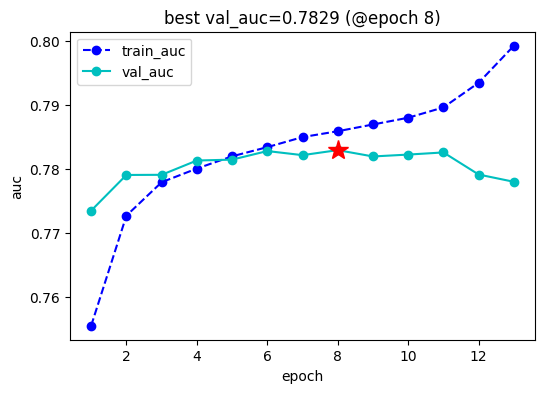

<<<<<< val_auc without improvement in 5 epoch,early stopping >>>>>> 



In [12]:
dfhistory = model.fit(train_data = dl_train,
    val_data = dl_val,
    epochs=100,
    ckpt_path='checkpoint',
    patience=5,
    monitor='val_auc',
    mode='max',
    plot=True,
    cpu=True
)

### 4，评估模型

In [13]:
model.evaluate(dl_test)

100%|████████████████████████████████| 98/98 [00:16<00:00,  5.99it/s, val_auc=0.781, val_loss=0.466]


{'val_loss': 0.46646365553748853, 'val_auc': 0.781028687953949}

### 5，使用模型

In [14]:
from sklearn.metrics import roc_auc_score
model.eval()
dl_test = model.accelerator.prepare(dl_test)
with torch.no_grad():
    result = torch.cat([model.forward(t[0]) for t in dl_test])

preds = F.sigmoid(result)
labels = torch.cat([x[-1] for x in dl_test])

val_auc = roc_auc_score(labels.numpy(),preds.numpy())
print(val_auc)


0.7810287729660677


### 6，保存模型

模型最佳权重已经保存在 model.fit(ckpt_path) 传入的参数中了。

In [ ]:
net_clone = create_net()
net_clone.load_state_dict(torch.load(model.ckpt_path))

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)